In [1]:
import os
import pandas as pd
from pandas import DataFrame
import re
import numpy as np
import random
import nltk
from nltk import word_tokenize
from typing import List, Dict, Any
nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/mynguyen/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Parsing: NYT article headline

In [ ]:
PATH = "../dataset/"
domain = "article"
file = "nyt/nyt-articles-2020.csv"
file_path = os.path.join(PATH,domain,file)


In [ ]:
dataframe = pd.read_csv(file_path).reset_index()

In [ ]:
# get Headline and second headline
dataframe.head()

In [ ]:
top_newdesks = dataframe.newsdesk.value_counts()
# .index[:5]
print(top_newdesks)

top_newdesks = ["Business"]

In [ ]:
dataframe_filtered = dataframe[dataframe["newsdesk"].isin(top_newdesks)].copy()

In [ ]:
dataframe_headline = dataframe_filtered[["index", "headline"]].copy()

In [ ]:
dataframe_headline.head()

For Sentences, we need to first create a dictionary for all the words appear in the model.
So the number of words in the dictionary will be the number of neurons in the input layer

In [ ]:
test_str = "It's, raining.?"

re.sub("\?|\.|\,", "", test_str)

In [ ]:
# Let's not worry about punctuation right now
# but punctuation can help with formulating grammar
dataframe_headline["headline"] = dataframe_headline["headline"].apply(lambda x: re.sub("\'|\!|\?|\.|\|\(|\)|\,|\(|\)", "", x))

In [ ]:
dataframe_headline["headline"].head()

### Parsing: dialogs

In [ ]:
PATH = "../dataset/"
domain = "chat"
file = "dialogs.txt"
file_path = os.path.join(PATH,domain,file)


In [ ]:
# read text data
with open(file_path, mode="r") as file:
    rows = file.readlines()
    rows = [row.replace("\t"," ").replace("\n", "") for row in rows]
    sentences = [nltk.sent_tokenize(row)[0] for row in rows]
    dataframe = pd.DataFrame(sentences, columns=["message"]).reset_index()

In [ ]:
dataframe.shape

In [ ]:
dataframe["message"] = dataframe["message"].apply(lambda x: re.sub("\'|\!|\?|\.|\|\(|\)|\,|\(|\)", "", x))

### Question Answer

In [2]:
PATH = "../dataset/"
domain = "qa"
file = "S08_question_answer_pairs.txt"
file_path = os.path.join(PATH,domain,file)

In [3]:
with open(file_path, mode="r") as file:
    dataframe = pd.read_csv(file, delimiter="\t").reset_index()

In [4]:
dataframe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1715 entries, 0 to 1714
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   index                     1715 non-null   int64 
 1   ArticleTitle              1715 non-null   object
 2   Question                  1696 non-null   object
 3   Answer                    1475 non-null   object
 4   DifficultyFromQuestioner  1224 non-null   object
 5   DifficultyFromAnswerer    1473 non-null   object
 6   ArticleFile               1713 non-null   object
dtypes: int64(1), object(6)
memory usage: 93.9+ KB


In [5]:
dataframe.head()

,index,ArticleTitle,Question,Answer,DifficultyFromQuestioner,DifficultyFromAnswerer,ArticleFile
0,0,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,yes,easy,easy,S08_set3_a4
1,1,Abraham_Lincoln,Was Abraham Lincoln the sixteenth President of...,Yes.,easy,easy,S08_set3_a4
2,2,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,yes,easy,medium,S08_set3_a4
3,3,Abraham_Lincoln,Did Lincoln sign the National Banking Act of 1...,Yes.,easy,easy,S08_set3_a4
4,4,Abraham_Lincoln,Did his mother die of pneumonia?,no,easy,medium,S08_set3_a4


In [6]:
# lower case col
dataframe.columns = [col.lower() for col in dataframe.columns] 

In [7]:
# lower case value
dataframe.question = dataframe.question.apply(lambda x: str(x).lower())

In [8]:
# remove punctuation
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("\!|\?|\|\(|\)|,|\(|\)", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("-rrb-", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("-lrb-", "", x))
dataframe["question"] = dataframe["question"].apply(lambda x: re.sub("[^a-zA-z0-9\s]", "", x))

In [9]:
dataframe.head()

,index,articletitle,question,answer,difficultyfromquestioner,difficultyfromanswerer,articlefile
0,0,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,S08_set3_a4
1,1,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,Yes.,easy,easy,S08_set3_a4
2,2,Abraham_Lincoln,did lincoln sign the national banking act of 1863,yes,easy,medium,S08_set3_a4
3,3,Abraham_Lincoln,did lincoln sign the national banking act of 1863,Yes.,easy,easy,S08_set3_a4
4,4,Abraham_Lincoln,did his mother die of pneumonia,no,easy,medium,S08_set3_a4


In [11]:
dataframe.articletitle.value_counts().index[np.where(dataframe.articletitle.value_counts().values >= 50)]

Index(['Calvin_Coolidge', 'Finland', 'Singapore', 'James_Monroe', 'Uruguay',
       'kangaroo', 'turtle', 'otter', 'Amedeo_Avogadro', 'Canada', 'leopard',
       'Ghana', 'Millard_Fillmore', 'Abraham_Lincoln', 'elephant', 'duck',
       'Liechtenstein', 'penguin'],
      dtype='object')

In [10]:
print(dataframe[dataframe["question"].str.contains("finland")]["question"].values)

['is the most read newspaper in finland taloussanomat'
 'is the most read newspaper in finland taloussanomat'
 'which russian army general conquered finland in 1809'
 'which russian army general conquered finland in 1809'
 'what is the life expectancy for men in finland'
 'what is the life expectancy for men in finland'
 'what body of water lies to the south of finland'
 'what body of water lies to the south of finland'
 'today are there more cell phone subscriptions than people in finland'
 'today are there more cell phone subscriptions than people in finland'
 'is matti vanhanen the prime minister of finland'
 'is matti vanhanen the prime minister of finland'
 'what is the biggest city in finland'
 'what is the biggest city in finland'
 'who is the most popular rock group in finland'
 'who is the most popular rock group in finland'
 'what is finlands economy like' 'where is finland located'
 'where is finland located'
 'are there cathedrals scattered all across finland'
 'are there c

### Proccessing

In [12]:
# Generate dictionary of words coming from the source data

def create_vocab_mapping(sequences):
    """
    from input sequences of tokens for each string, add to dictionary
    """
    vocabulary_mapping = {}
    list_of_vocab = {}
    index_cnt = 0

    for words in sequences:
        for token in words:
            try:
                list_of_vocab[token] += 1
            except Exception as error:
                list_of_vocab[token] = 1

    # creating vocab
    randomized_list_of_vocab = list(list_of_vocab.keys())
    random.shuffle(randomized_list_of_vocab)
    
    for word in randomized_list_of_vocab:
        vocabulary_mapping[index_cnt] = word
        index_cnt += 1
    return vocabulary_mapping, list_of_vocab

def create_tokens(dataframe, column) -> List[str]:
    """
    From column in a dataframe, process each input string
    and return a list of tokens
    """
    dataframe_processing = dataframe[column]
    dataframe_processing = dataframe_processing.drop_duplicates()
    sentences = []

    for row in dataframe_processing:
        words = word_tokenize(row)
        words.append("</s>")
        sentences.append(words)

    # randomize input sentences for training
    random.shuffle(sentences)
    return sentences


In [13]:
def count_words():
    """
    Return Frequency of words in a dataset, and number of 
    sentences containing those words
    """
    pass

In [15]:
# narrow dataframe to just Abraham Lincoln
dataframe = dataframe[dataframe["question"].str.contains("lincoln")]
sentences = create_tokens(dataframe, "question")
vocabulary_mapping, list_of_vocab = create_vocab_mapping(sentences)
input_size = len(vocabulary_mapping)
input_size

96

In [41]:
dataframe

,index,articletitle,question,answer,difficultyfromquestioner,difficultyfromanswerer,articlefile
0,0,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,yes,easy,easy,S08_set3_a4
1,1,Abraham_Lincoln,was abraham lincoln the sixteenth president of...,Yes.,easy,easy,S08_set3_a4
2,2,Abraham_Lincoln,did lincoln sign the national banking act of 1863,yes,easy,medium,S08_set3_a4
3,3,Abraham_Lincoln,did lincoln sign the national banking act of 1863,Yes.,easy,easy,S08_set3_a4
6,6,Abraham_Lincoln,how many long was lincolns formal education,18 months,medium,easy,S08_set3_a4
7,7,Abraham_Lincoln,how many long was lincolns formal education,18 months.,medium,medium,S08_set3_a4
8,8,Abraham_Lincoln,when did lincoln begin his political career,1832,medium,easy,S08_set3_a4
9,9,Abraham_Lincoln,when did lincoln begin his political career,1832.,medium,medium,S08_set3_a4
12,12,Abraham_Lincoln,who suggested lincoln grow a beard,11-year-old Grace Bedell,hard,medium,S08_set3_a4
13,13,Abraham_Lincoln,who suggested lincoln grow a beard,Grace Bedell.,hard,medium,S08_set3_a4


In [17]:
# dict(sorted(list_of_vocab.items(), key=lambda item: item[0]))
len(sentences)

24

In [16]:
vocabulary_mapping

{0: 'use',
 1: '1863',
 2: 'born',
 3: 'john',
 4: 'top',
 5: 'education',
 6: 'breckinridge',
 7: 'almanac',
 8: 'sangamon',
 9: 'slavery',
 10: 'begin',
 11: 'suggested',
 12: 'of',
 13: 'when',
 14: 'effective',
 15: 'ever',
 16: 'the',
 17: 'election',
 18: '1860',
 19: 'why',
 20: 'lincoln',
 21: 'alton',
 22: 'political',
 23: 'frontier',
 24: 'many',
 25: 'presidents',
 26: '4',
 27: 'abraham',
 28: 'presidential',
 29: 'candidate',
 30: 'in',
 31: 'as',
 32: 'among',
 33: 'states',
 34: 'did',
 35: 'how',
 36: 'photgraph',
 37: 'live',
 38: 'was',
 39: 'grow',
 40: 'railroad',
 41: 'c',
 42: 'old',
 43: '1832',
 44: 'who',
 45: 'taken',
 46: 'issue',
 47: 'months',
 48: 'support',
 49: 'united',
 50: 'start',
 51: 'president',
 52: 'sixteenth',
 53: '18',
 54: 'county',
 55: 'legal',
 56: 'act',
 57: 'career',
 58: 'chosen',
 59: 'beard',
 60: 'banking',
 61: 'july',
 62: 'promote',
 63: 'national',
 64: 'rank',
 65: 'assassinated',
 66: 'scholars',
 67: 'schooling',
 68: 'regu

### Encoding

In [18]:
import torch

/Users/mynguyen/Repos/language-helper/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [19]:
def find_word_index(word):
    """
    Look up word index in vocabulary dictionary
    """
    value = [index for index in vocabulary_mapping.keys() if vocabulary_mapping[index] == word]
    return value[0]


def sentence_to_tensor(sentences):
    tensor = torch.zeros(len(sentences), 1, len(vocabulary_mapping))
    for sentence, word in enumerate(sentences):
        index = find_word_index(word)
        tensor[sentence][0][index] = 1
    return tensor


def formulate_target(sentences: List[str]):
    """
    For example:
    string: This is a test

    embedded tensor:
    This = [[[]]]

    target: is
    """
    orig_size = len(sentences)
    x_sentence = sentences[:-1]
    y_sentence = sentences[1:]
    x_tensor = sentence_to_tensor(sentences=x_sentence)
    y_tensor = sentence_to_tensor(sentences=y_sentence)
    return x_tensor, y_tensor



In [20]:
# 996: 'Biking'
find_word_index("president")

51

In [21]:
print(f"Input: {sentences[0]}")
tensor = sentence_to_tensor(sentences[0])

Input: ['did', 'abraham', 'lincoln', 'live', 'in', 'the', 'frontier', '</s>']


In [22]:
print(tensor.shape)

torch.Size([8, 1, 96])


In [23]:
x_tensor, y_tensor = formulate_target(sentences=sentences[0])

In [24]:
x_tensor.shape

torch.Size([7, 1, 96])

In [25]:
y_tensor.shape

torch.Size([7, 1, 96])

In [26]:
# checking if x tensor and y tensor are different (they should be)
for i in x_tensor[0][0] == y_tensor[0][0]:
    if not i: 
        print(i)

tensor(False)
tensor(False)


### Building Models

In [27]:
import torch.nn as nn
from torch.autograd import Variable
from torch.optim import Adam
from torch import FloatTensor, randn, zeros

In [28]:
INPUT_SIZE = len(vocabulary_mapping)
HIDDEN_SIZE = 256
OUPUT_SIZE = len(vocabulary_mapping)
LEARNING_RATE = 0.001

In [29]:
class RNN(nn.Module):
    """
    simple RNN network with 1 layer
    """
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN, self).__init__()

        self.hidden_size = hidden_size

        self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
        self.i2o = nn.Linear(input_size + hidden_size, output_size)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(output_size, output_size)
        # self.softmax = nn.LogSoftmax()

    def forward(self, input, hidden):
        combined = torch.cat((input, hidden), 1)
        hidden_t = self.i2h(combined)
        output = self.i2o(combined)
        drop_output = self.dropout(output)
        logits = self.fc(drop_output)
        # do not need softmax if using CrossEntropyLoss
        # https://stackoverflow.com/questions/55675345/should-i-use-softmax-as-output-when-using-cross-entropy-loss-in-pytorch
        return logits, hidden_t
        
    
    def init_hidden(self):
        return Variable(torch.zeros(1, self.hidden_size))

In [30]:
class LSTM(nn.Module):
    def __init__(self):
        super(LSTM, self).__init__()

### Training Model

In [31]:
# Demonstrating how model interact
def predict(input_sentence, rnn, output_length=None):
    predicted_str = []
    rnn.eval()
    hidden = rnn.init_hidden()
    for i in range(output_length+1):     
        hidden = rnn.init_hidden()   
        x_input = sentence_to_tensor(input_sentence)
        x_input = Variable(x_input)
        
        hidden = Variable(torch.zeros(1, HIDDEN_SIZE))
        output, next_hidden = rnn(x_input[0], hidden)

        # get the token probabilities
        p = torch.nn.functional.softmax(output, dim=1).data

        # use top 1 word as next input
        input_sentence = [vocabulary_mapping[int(output.data.topk(1).indices[0][0])]]
        print(f"next input {input_sentence}")
        predicted_str.append((input_sentence, p[0]))
    return predicted_str

#### What is Backpropagation in LSTM's language model


#### What is Issue of Vanishing Gradient


#### What is CrossEntropyLoss for LSTM's language model


#### What is the Optimizer we can use in LSTM


#### What is checkpoint


In [32]:
len(sentences)

24

In [36]:
# training
# torch.autograd.set_detect_anomaly(True)
#  initialize rnn instance
rnn = RNN(INPUT_SIZE, HIDDEN_SIZE, OUPUT_SIZE)
n_iterations = 15
hidden = rnn.init_hidden()
# rnn.zero_grad()

total_loss = 0
training_result = []

# measuring differences between predicted probability distribution 
# versus the actual
criterion = nn.CrossEntropyLoss()


# define an optimizer
# rnn.train()

optimizer = Adam(rnn.parameters(), lr=LEARNING_RATE)

# define epoch for training
# for each iteration, pick a sentence for training
for iter in range(1, n_iterations+1):
    rnn.zero_grad()

    # select an input for training
    
    total_loss = 0
    # sentence = np.random.choice(sentences)
    sentence = sentences[iter]
    
    # wrap tensor in Variable
    x_tensor, y_tensor = formulate_target(sentence)
    x_tensor_wrap = Variable(x_tensor)
    y_tensor_wrap = Variable(y_tensor)

    for index in range(x_tensor_wrap.size()[0]):
        # zero gradient
        rnn.zero_grad()
        # optimizer.zero_grad()

        output, hidden = rnn(x_tensor_wrap[index], hidden)

        # to evaluate output, we need to compare generated output
        # against the actual next word
       
        # after training each word in input sequence, calculate loss
        loss = criterion(output, y_tensor_wrap[index])
        hidden.detach()
        total_loss += loss.item()
        
        # https://discuss.pytorch.org/t/runtimeerror-trying-to-backward-through-the-graph-a-second-time-but-the-buffers-have-already-been-freed-specify-retain-graph-true-when-calling-backward-the-first-time/6795/2
        # To reduce memory usage, during the .backward() call, all the intermediary results
        # are deleted when they are not needed anymore. Hence if you try to call .backward() again,
        # the intermediary results don’t exist and the backward pass cannot be performed (and you get the error you see).
        # You can call .backward(retain_graph=True) to make a backward pass that will not delete intermediary results
    
        loss.backward(retain_graph=True)
        
        nn.utils.clip_grad_norm_(rnn.parameters(), 1)
        # optimizer.step()

    # average the training loss for the sentence (due to sentence might have more token)
    avg_loss = total_loss/x_tensor.size()[0]
        

    # update weights
    for p in rnn.parameters():
        try:
            p.data.sub_(-LEARNING_RATE, p.grad.data)
        except Exception as e:
            print("Skipping")
            
    # early stopping if loss stop decreasing
    # https://github.com/Bjarten/early-stopping-pytorch
    
    print(f"Iter {iter}")
    print(f"Loss {avg_loss}")

    # only adding total loss training for each sentence to training result
    training_result.append(float(avg_loss))
    

Iter 1
Loss 4.5921276092529295
Iter 2
Loss 4.586153030395508
Iter 3
Loss 4.583510671343122
Iter 4
Loss 4.598835786183675
Iter 5
Loss 4.588763100760324
Iter 6
Loss 4.56066550148858
Iter 7
Loss 4.554253986903599
Iter 8
Loss 4.560214948654175
Iter 9
Loss 4.5956259568532305
Iter 10
Loss 4.56657567024231
Iter 11
Loss 4.599438599177769
Iter 12
Loss 4.589988708496094
Iter 13
Loss 4.609184900919597
Iter 14
Loss 4.59403642018636
Iter 15
Loss 4.570677399635315


In [40]:
training_result[-10:]

[7.879787649427142,
 7.896685695648193,
 7.864547284444173,
 7.872136506167325,
 7.888607025146484,
 7.86925208568573,
 7.881708701451619,
 7.879568576812744,
 7.874557290758405,
 7.875260233879089]

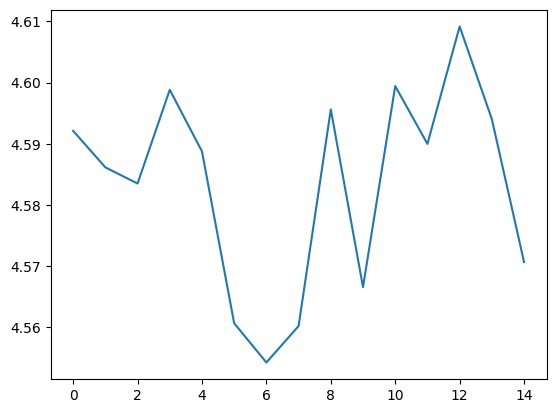

In [37]:
from matplotlib import pyplot as plt

plt.plot(training_result)
plt.show()

In [39]:
x_input = sentence_to_tensor(["was"])
x_input = Variable(x_input)
x_input[0]

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.]])

In [45]:
# predict
result = {}
output = predict([""], rnn, 4)

# print results
print(output)



IndexError: list index out of range

In [75]:
vocabulary_mapping[1261]
list_of_vocab["nor"]

1

### Evalutation